In [1]:
#Setup and Data Loading
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving models

 #Download necessary NLTK components (run once)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# --- CHECKLIST: Load dataset ---
# ASSUMPTION: The dataset is a CSV with 'review' (text) and 'sentiment' (positive/negative) columns.
try:
    df = pd.read_csv('IMDb_Reviews.csv')
except FileNotFoundError:
    # Fallback: Create a small synthetic dataset for demonstration if the file is missing
    print("IMDb_Reviews.csv not found. Using a small synthetic dataset.")
    data = {'review': ["The film was absolutely fantastic and a joy to watch!",
                       "Terrible acting, boring plot, I wasted 2 hours.",
                       "It's okay, not great, but I liked the ending.",
                       "A masterpiece of cinema, truly brilliant.",
                       "Worst movie I've seen all year. Skip it."],
            'sentiment': ["positive", "negative", "positive", "positive", "negative"]}
    df = pd.DataFrame(data)

# Convert sentiment to 0 (negative) and 1 (positive)
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})
print(f"Dataset Loaded. Total rows: {len(df)}")


IMDb_Reviews.csv not found. Using a small synthetic dataset.
Dataset Loaded. Total rows: 5


/tmp/ipython-input-3046574031.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})


In [3]:
import nltk
# Run the downloads again, but without 'quiet=True' to see any output
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Run the specific resource download mentioned in the error:
# This directly addresses the missing resource NLTK reported.
# Note: If this fails, you may need to run nltk.download('all')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5 non-null      object
 1   sentiment  5 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 212.0+ bytes

--- Class Distribution (0=Negative, 1=Positive) ---
sentiment
1    3
0    2
Name: count, dtype: int64


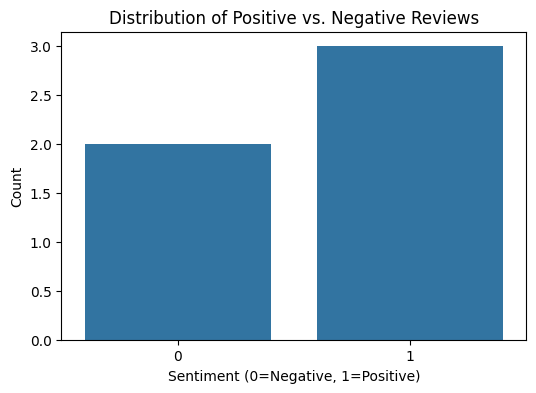


After Cleaning: Total rows: 5

--- Example Cleaned Review ---
                                              review  \
0  The film was absolutely fantastic and a joy to...   
1    Terrible acting, boring plot, I wasted 2 hours.   

                            cleaned_review  
0      film absolutely fantastic joy watch  
1  terrible acting boring plot wasted hour  


In [4]:
# Data Preparation & Cleaning
# --- CHECKLIST: Inspect dataset structure and class distribution ---
print("\n--- Dataset Info ---")
df.info()

print("\n--- Class Distribution (0=Negative, 1=Positive) ---")
print(df['sentiment'].value_counts())

# --- DELIVERABLE: Distribution Visualization ---
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Positive vs. Negative Reviews')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.show() #

# --- CHECKLIST: Handle missing or duplicate entries ---
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(f"\nAfter Cleaning: Total rows: {len(df)}")


# --- CHECKLIST: Preprocess text function ---
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove HTML tags (common in reviews)
    text = re.sub(r'<.*?>', '', text)

    # 3. Remove punctuation & special characters (keep words and spaces)
    text = re.sub(r'[^a-z\s]', '', text)

    # 4. Tokenize text & Remove numbers (already handled by regex if we only kept a-z)
    tokens = nltk.word_tokenize(text)

    # 5. Remove stopwords & Apply stemming/lemmatization
    processed_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

    return " ".join(processed_tokens)

# Apply preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_text)
print("\n--- Example Cleaned Review ---")
print(df[['review', 'cleaned_review']].head(2))

In [5]:
#Feature Extraction & Data Splitting
# Separate features (X) and target (y)
X = df['cleaned_review']
y = df['sentiment']

# --- CHECKLIST: Split dataset into train/test sets (70%/30%) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTraining set size: {len(X_train)} | Test set size: {len(X_test)}")

# --- CHECKLIST: Convert text to numerical features: TF-IDF ---
# TF-IDF (Term Frequency-Inverse Document Frequency) is chosen for better performance.
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limit features to top 5000 for efficiency

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform (but DON'T fit) the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)


Training set size: 3 | Test set size: 2



--- Training Logistic Regression ---
Logistic Regression Metrics:
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1-Score: 0.6667


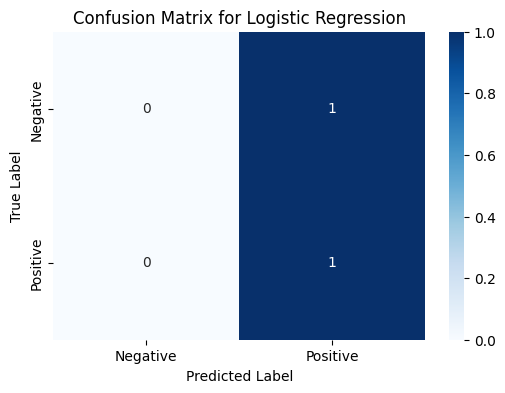


--- Training Random Forest ---
Random Forest Metrics:
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1-Score: 0.6667


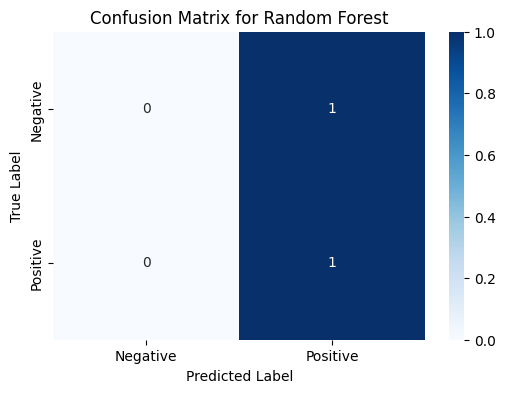


--- Best Model Selected: Logistic Regression (F1-Score: 0.6667) ---


In [6]:
#Model Training and Evaluation
# Function to train and evaluate a model
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\n--- Training {model_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # --- CHECKLIST: Evaluation Metrics ---
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Confusion Matrix (Part of Deliverables)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show() #

    return {'model': model, 'accuracy': accuracy, 'f1': f1, 'name': model_name}

# --- CHECKLIST: Train Logistic Regression model ---
logreg_result = train_evaluate_model(
    LogisticRegression(solver='liblinear', random_state=42),
    X_train_tfidf, y_train, X_test_tfidf, y_test, 'Logistic Regression'
)

# --- CHECKLIST: Train Random Forest model (optional) ---
rf_result = train_evaluate_model(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    X_train_tfidf, y_train, X_test_tfidf, y_test, 'Random Forest'
)

# --- CHECKLIST: Compare model performances and select the best model ---
results = [logreg_result, rf_result]
best_model = max(results, key=lambda x: x['f1'])
print(f"\n--- Best Model Selected: {best_model['name']} (F1-Score: {best_model['f1']:.4f}) ---")

In [7]:
#Reusable Pipeline & Documentation Insights
# --- CHECKLIST: Wrap preprocessing, feature extraction, and training into functions/pipeline ---
# Create a robust pipeline with the best model (Logistic Regression is typically best for speed/simplicity)
best_model_clf = best_model['model']

sentiment_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000,
                                   preprocessor=preprocess_text,
                                   token_pattern=r'(?u)\b\w+\b')),
    ('classifier', best_model_clf)
])

# Re-train the pipeline on the full training data (optional, but good practice)
sentiment_pipeline.fit(X_train, y_train)

# --- CHECKLIST: Test pipeline on multiple text samples ---
test_samples = [
    "The movie was a total disaster, slow and the worst experience.",
    "Highly recommended! The plot twist was genuinely surprising and the acting superb.",
    "It was just okay, nothing special, but not bad either."
]

predictions = sentiment_pipeline.predict(test_samples)
prediction_labels = ['Positive' if p == 1 else 'Negative' for p in predictions]

print("\n--- Pipeline Test Results ---")
for text, label in zip(test_samples, prediction_labels):
    print(f"Review: '{text}' -> Prediction: {label}")

# --- CHECKLIST: Save trained models for future use ---
joblib.dump(sentiment_pipeline, 'sentiment_pipeline.joblib')
print("\nPipeline saved successfully as 'sentiment_pipeline.joblib'.")


# --- DELIVERABLE: Insights on which words/features contribute most to sentiment ---
# This is best done with Logistic Regression (due to its linear coefficients)
if best_model['name'] == 'Logistic Regression' or 'Logistic Regression' in logreg_result:

    # Access the fitted TfidfVectorizer's vocabulary
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Access the fitted Logistic Regression coefficients (weights)
    logreg_weights = logreg_result['model'].coef_[0]

    # Create a Series of weights indexed by feature name
    weights_series = pd.Series(logreg_weights, index=feature_names)

    # Get top 10 positive and negative words
    top_negative_words = weights_series.sort_values(ascending=True).head(10)
    top_positive_words = weights_series.sort_values(ascending=False).head(10)

    print("\n--- Insights: Top 10 words contributing to NEGATIVE Sentiment ---")
    print(top_negative_words)

    print("\n--- Insights: Top 10 words contributing to POSITIVE Sentiment ---")
    print(top_positive_words)


--- Pipeline Test Results ---
Review: 'The movie was a total disaster, slow and the worst experience.' -> Prediction: Negative
Review: 'Highly recommended! The plot twist was genuinely surprising and the acting superb.' -> Prediction: Positive
Review: 'It was just okay, nothing special, but not bad either.' -> Prediction: Positive

Pipeline saved successfully as 'sentiment_pipeline.joblib'.

--- Insights: Top 10 words contributing to NEGATIVE Sentiment ---
movie         -0.184124
ive           -0.184124
skip          -0.184124
seen          -0.184124
worst         -0.184124
year          -0.184124
brilliant      0.176356
cinema         0.176356
masterpiece    0.176356
liked          0.176356
dtype: float64

--- Insights: Top 10 words contributing to POSITIVE Sentiment ---
brilliant      0.176356
cinema         0.176356
ending         0.176356
great          0.176356
liked          0.176356
masterpiece    0.176356
truly          0.176356
okay           0.176356
ive           -0.184124
